# Clasificación rápida en ALeRCE utilizando selección de características y algoritmos genéticos.

Integrantes: Joaquín Cubelli - Tomás de la Sotta

Profesor de Cátedra: Pablo Estévez<br>
Profesor Auxiliar: Ignacio Reyes<br>
Ayudantes: Francisca Cona, Jhon Intriago, Pablo Montero, Óscar Pimentel, Esteban Reyes, Mauricio Romero

El broker astronómico ALeRCE clasifica objetos en tiempo real todas las noches. Para ello utiliza dos modelos, un clasificador basado en estampillas para detección rápida de transientes y un clasificador basado en curvas de luz que utiliza una taxonomía detallada. El clasificador de curvas de luz, descrito en Sánchez-Sáez et al. (2020), consiste en la extracción de múltiples características a partir de las curvas de luz (y otras fuentes de datos) y un modelo basado en Random Forests.

El objetivo de este proyecto es reducir el número de características utilizadas por el clasificador de curvas de luz de ALeRCE, explorando el compromiso entre el desempeño en clasificación y el costo computacional asociado.

La primera etapa del proyecto consiste en **evaluar la estrategia greedy para seleccionar las características más relevantes al momento de clasificar**. En esta estrategia se explorará una característica a la vez, buscando cuál de ellas ayuda más al desempeño del modelo cuando es agregada al conjunto de características utilizadas. También se deberá probar comenzando con todas las características y removiendo una característica a la vez. 

Notar que en esta etapa no se toma en cuenta explícitamente el costo de computar cada característica al momento de efectuar la selección.

Ref: Sánchez-Sáez, P., et al. "Alert Classification for the ALeRCE Broker System: The Light Curve Classifier." arXiv preprint arXiv:2008.03311 (2020).
Ref: Huang, Cheng-Lung, and Chieh-Jen Wang. "A GA-based feature selection and parameters optimization for support vector machines." Expert Systems with applications 31.2 (2006): 231-240. Nota: Tomar como referencia, no como pauta a la cual seguir al pie de la letra. 

Pasos a seguir:
- Dividir los datos en entrenamiento y test (70 %, 30 %), con particionamiento estratificado (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) y normalizar features. Se recomienda QuantileTransformer de scikit-learn. Si el feature no está disponible puede usar un valor -1.0 por ejemplo. Recuerden descartar features baneadas.
- Entrenar un Random Forest balanceado (https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.BalancedRandomForestClassifier.html).
- Reportar métricas de desempeño (Accuracy, F1-score).
- Identificar si existe algún pack de features irrelevantes (i.e. que al sacarlo no cambia el desempeño).
- Implementar estrategia greedy (debe estar corriendo para meeting 2, aunque tal vez no tengan listos los resultados o ambos métodos greedy)

## Te voy a pedir que sigas instrucciones del final Dela.

In [1]:
# Correr una vez.

# !pip install --upgrade pip
# !pip install pyarrow
# !pip install -U imbalanced-learn

In [2]:
# Imports:

# Procesamiento de datos.
from pathlib import Path

import sys
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

# Tensorflow y asociados.

import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
import sklearn.preprocessing as skp

## Datos para el Proyecto:

Detecciones: https://droppy.alerce.online/$/LLaeQ

No detecciones: https://droppy.alerce.online/$/PrIbP

Features: https://droppy.alerce.online/$/3x3qh

Etiquetas: https://droppy.alerce.online/$/XHsJO

Abrir con pandas. Algunos archivos tienen formato pickle (o parquet (?) https://arrow.apache.org/docs/python/parquet.html), otros CSV. 
Hay features que no deben usar, como por ejemplo el brillo promedio, ya que no queremos sesgar el análisis según qué tan cerca está el objeto.
Los _1 y _2 de los features indican a qué banda pertenece (banda g, banda r).

In [3]:
# Los features que no deben usar son:

banned_features = [
   'mean_mag_1',
   'mean_mag_2',
   'min_mag_1',
   'min_mag_2',
   'Mean_1',
   'Mean_2',
   'n_det_1',
   'n_det_2',
   'n_pos_1',
   'n_pos_2',
   'n_neg_1',
   'n_neg_2',
   'first_mag_1',
   'first_mag_2',
   'MHPS_non_zero_1',
   'MHPS_non_zero_2',
   'MHPS_PN_flag_1',
   'MHPS_PN_flag_2',
   #'W1', 'W2', 'W3', 'W4',
   'iqr_1',
   'iqr_2',
   'delta_mjd_fid_1',
   'delta_mjd_fid_2',
   'last_mjd_before_fid_1',
   'last_mjd_before_fid_2'#,
   #'g-r_ml',
   #'MHAOV_Period_1', 'MHAOV_Period_2'
]

# Datos comentados no se observaban en detecciones ni en no_detecciones

In [4]:
len(banned_features)

24

In [5]:
alerceClasses = ["AGN", "Blazar", "SNIa", ]

En el archivo con las etiquetas hay varias clases. Para el análisis agruparemos algunas clases según el siguiente diccionario (etiqueta original: nueva etiqueta)

In [6]:
# Directorios de datasets
Joaquin = False

if Joaquin:
    etiquetas_dir = "/Users/joaquincubelli/Desktop/Inteligencia Computacional/ALeRCE_data/Etiquetas/dfcrossmatches_prioritized_v7.0.1.csv" # csv
    features_dir = "/Users/joaquincubelli/Desktop/Inteligencia Computacional/ALeRCE_data/storage/ztf_workspace/historic_data_20200916/features_20200916.parquet" # parquet
    # Los siguientes directorios tienen datasets separados en múltiples archivos.
    detections_dir = Path("/Users/joaquincubelli/Desktop/Inteligencia Computacional/ALeRCE_data/detections_with_xmatch/") # parquet
    no_detections_dir = Path("/Users/joaquincubelli/Desktop/Inteligencia Computacional/ALeRCE_data/notdet_with_xmatch/") # parquet

else:
    etiquetas_dir = "/media/dela/1TB/A Universidad/Electrica/VIII Sem/Inteligencia Computacional/AlErCe/dfcrossmatches_prioritized_v7.0.1.csv" # csv
    features_dir = "/media/dela/1TB/A Universidad/Electrica/VIII Sem/Inteligencia Computacional/AlErCe/features/storage/ztf_workspace/historic_data_20200916/features_20200916.parquet" # parquet
    # Los siguientes directorios tienen datasets separados en múltiples archivos.
    detections_dir = Path("/media/dela/1TB/A Universidad/Electrica/VIII Sem/Inteligencia Computacional/AlErCe/detections_with_xmatch/") # parquet
    no_detections_dir = Path("/media/dela/1TB/A Universidad/Electrica/VIII Sem/Inteligencia Computacional/AlErCe/notdet_with_xmatch/") # parquet

### Lectura Etiquetas:

Por lo visto, en este dataset estan los nombres de cada objeto, junto con la clase respectiva, la posición, período, e información adicional de fuente.

Para este problema, no parece ser muy importante el archivo, salvo por la relación entre el nombre y el tipo de clase.

In [7]:
etiquetas = pd.read_csv(etiquetas_dir)
etiquetas

,oid,classALeRCE,ra,dec,period,source,id_source,class_source,separation_arcsec
0,ZTF19abegncu,AGN,357.296363,-8.941186,NaN,Oh2015,5.8772718059579e+17,AGN_galaxy_dominated,0.243081
1,ZTF18acejdhu,AGN,11.958444,-10.496615,NaN,Oh2015,5.877272256953059e+17,AGN_galaxy_dominated,0.301126
2,ZTF18acdzene,AGN,17.478620,-10.110250,NaN,Oh2015,5.877271789938934e+17,AGN_galaxy_dominated,0.158643
3,ZTF18abwzuzw,AGN,25.038255,-10.352430,NaN,Oh2015,5.877272294485526e+17,AGN_galaxy_dominated,0.485322
4,ZTF19abmposz,AGN,26.670031,-8.354787,NaN,Oh2015,5.877271806085038e+17,AGN_galaxy_dominated,0.213990
...,...,...,...,...,...,...,...,...,...
173874,ZTF18abikbvc,LPV,286.720222,24.733440,NaN,GAIADR2VS,4.533629080944307e+18,MIRA_SR,0.299487
173875,ZTF19aamtoyb,LPV,99.257590,-15.567786,NaN,GAIADR2VS,2.9501070744892713e+18,MIRA_SR,0.299597
173876,ZTF19abeesgk,LPV,277.499222,-27.002742,NaN,GAIADR2VS,4.0518162825206625e+18,MIRA_SR,0.299766
173877,ZTF18abnubuy,LPV,292.053754,38.418277,NaN,GAIADR2VS,2.0526959231045647e+18,MIRA_SR,0.299777


In [8]:
etiquetas = etiquetas[['oid','classALeRCE']]

### Lectura Features:

Por lo visto, este es el archivo a revisar, puesto a que tiene los nombres de cada objeto, con cada feature característica.
Sin embargo, en este archivo no aparece la clase de cada objeto, por lo que es necesario relacionar ambas databases para clasificación. 

Recordar que en las instrucciones nos muestran cómo manejar los NaN:
*Si el feature no está disponible puede usar un valor -1.0 por ejemplo. Recuerden descartar features baneadas.*

In [9]:
features = pd.read_parquet(features_dir)

In [10]:
features = features.drop(banned_features, axis=1)

Se asocian los features con las etiquetas

In [11]:
dataset = pd.merge(features, etiquetas, left_on='index', right_on='oid')

In [12]:
dataset = dataset.drop(['oid'], axis=1)

In [19]:
dataset_num = dataset.select_dtypes(include=[np.number])
norm_func = skp.QuantileTransformer(n_quantiles=1000, output_distribution='uniform')
dataset_norm = pd.DataFrame(norm_func.fit_transform(dataset_num))
#dataset_norm = (dataset_num - dataset_num.mean()) / (dataset_num.max() - dataset_num.min())
dataset[dataset_norm.columns] = dataset_norm
dataset = dataset.fillna(-1)

Dict = {
   "AGN": "AGN",
   "Blazar": "Blazar",
   "CV/Nova": "CV/Nova",
   "SNIa": "SNIa",
   "SNIbc": "SNIbc",
   "SNII": "SNII",
   "SNIIn": "SNII",
   "SLSN": "SLSN",
   "EA": "E",
   "EB/EW": "E",
   "DSCT": "DSCT",
   "RRL": "RRL",
   "Ceph": "CEP",
   "LPV": "LPV",
   "Periodic-Other": "Periodic-Other",
   "QSO": "QSO",
   "YSO": "YSO",
   "RSCVn": "Periodic-Other"
 }

dataset = dataset.replace(to_replace = Dict)

ticks = []
for et in dataset['classALeRCE']:
    if et not in ticks:
        ticks.append(et)
print(ticks)

['Periodic-Other', 'E', 'RRL', 'LPV', 'YSO', 'Blazar', 'QSO', 'DSCT', 'SNIa', 'AGN', 'CV/Nova', 'SNIbc', 'SNII', 'CEP', 'NLQSO', 'NLAGN', 'SLSN', 'SNIIb', 'TDE', 'ZZ']


In [20]:
lista = []
for x, y in Dict.items():
    lista.append(y)

In [21]:
classes = set(lista)

In [22]:
len(classes)

15

In [23]:
dataset = dataset[dataset.classALeRCE.isin(classes)]

In [24]:
dataset

,index,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,...,286,287,288,289,290,291,292,293,294,295
0,ZTF17aaabgdt,0.164834,-1.000000,0.762395,-1.000000,1.0,-1.0,0.285714,-1.000000,0.000000,...,0.000000,0.000000,0.188188,0.000000,0.190190,0.000000,0.515015,0.000000,0.674675,0.204454
1,ZTF17aaadfsa,0.196974,0.185956,1.000000,1.000000,2.0,1.0,0.405405,0.470588,0.000000,...,0.000000,0.000000,0.554054,0.716717,0.190190,0.175175,0.492492,0.585085,0.470971,0.486486
2,ZTF17aaadxdb,0.253045,0.349630,1.000000,1.000000,1.0,1.0,0.500000,0.350000,0.000000,...,0.000000,0.000000,0.820320,0.883884,0.190190,0.175175,0.472329,0.519970,0.169670,0.287432
3,ZTF17aaadzlq,2.482923,1.983951,1.000000,1.000000,13.0,14.0,0.531646,0.469925,0.038298,...,0.000000,0.000000,0.576577,0.442943,0.190190,0.175175,0.265448,0.272337,0.492993,0.201258
4,ZTF17aaaenfy,0.487668,0.455345,1.000000,1.000000,1.0,1.0,0.344444,0.318182,0.000000,...,0.943258,0.000000,0.897898,0.840841,0.417417,0.175175,0.651863,0.567395,0.803303,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118464,ZTF20aauowvs,0.111170,0.074701,0.812132,0.893797,1.0,1.0,0.250000,0.263158,0.000000,...,0.612007,0.319565,0.301301,0.325826,0.612613,0.458959,1.000000,1.000000,0.612112,1.000000
118465,ZTF20aawxcal,0.062353,-1.000000,0.965966,-1.000000,1.0,-1.0,0.428571,-1.000000,0.000000,...,0.847968,0.735445,0.752252,0.540040,0.983984,0.997547,0.116617,0.149149,0.993493,0.358358
118466,ZTF20abawiqv,0.033677,-1.000000,0.450214,-1.000000,1.0,-1.0,0.285714,-1.000000,0.000000,...,0.879524,0.000000,0.209710,0.000000,0.789790,0.000000,1.000000,0.000000,0.976977,0.018857
118467,ZTF20abcxmfu,0.200823,0.146211,0.765089,0.415971,5.0,7.0,0.272727,0.344828,0.000000,...,0.000000,0.000000,0.043043,0.065566,0.190190,0.175175,1.000000,1.000000,0.947447,0.257942


### División dataset:

In [25]:
X_train, X_test, y_train, y_test = train_test_split(dataset.select_dtypes(include=[np.number]), dataset['classALeRCE'], test_size=0.33, random_state=42)

### Entrenar Modelo

In [26]:
clf=BalancedRandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            class_weight=None,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)
clf.fit(X_train, y_train)

BalancedRandomForestClassifier(criterion='entropy', n_estimators=500, n_jobs=-1)

In [55]:
y_pred = clf.predict(X_test)

featuresCopy = np.copy(dataset.columns[1:])
featuresCopy = np.delete(featuresCopy, np.where(featuresCopy == 'classALeRCE'))


fI = clf.feature_importances_
ImportanceRank = []

while not np.all(fI == -1):
    maxArg = np.argmax(fI)
    ImportanceRank.append(featuresCopy[maxArg])
    fI[maxArg] = -1
    
print(ImportanceRank)

[147, 295, 'sgscore1', 145, 'SPM_chi_1', 98, 48, 196, 66, 246, 214, 'positive_fraction_2', 'IAR_phi_1', 51, 'Multiband_period', 197, 293, 125, 'positive_fraction_1', 'IAR_phi_2', 49, 'g-r_mean', 'SF_ML_amplitude_2', 144, 273, 243, 272, 126, 'SPM_A_1', 199, 248, 'SPM_A_2', 71, 'g-r_max_corr', 275, 274, 265, 1, 'Period_band_1', 124, 101, 292, 254, 'g-r_max', 'delta_mag_fid_2', 127, 247, 16, 264, 95, 239, 94, 219, 242, 'SPM_chi_2', 255, 'SPM_tau_rise_1', 'LinearTrend_2', 17, 164, 165, 117, 116, 'ExcessVar_1', 'n_non_det_after_fid_2', 'GP_DRW_tau_1', 294, 'Rcs_2', 289, 'SPM_tau_rise_2', 'g-r_mean_corr', 106, 100, 'delta_mag_fid_1', 99, 250, 160, 146, 'Amplitude_1', 'SPM_gamma_2', 149, 'MHPS_low_2', 'PercentAmplitude_1', 249, 104, 89, 237, 12, 'MHPS_high_1', 141, 'GP_DRW_tau_2', 208, 91, 'SPM_gamma_1', 'Period_band_2', 'Meanvariance_1', 128, 148, 261, 107, 56, 54, 'SPM_tau_fall_1', 252, 163, 14, 61, 0, 'gal_b', 'rb', 200, 72, 69, 162, 218, 'ExcessVar_2', 'MHPS_low_1', 221, 60, 251, 15, 102,

Text(246.5, 0.5, 'True label')

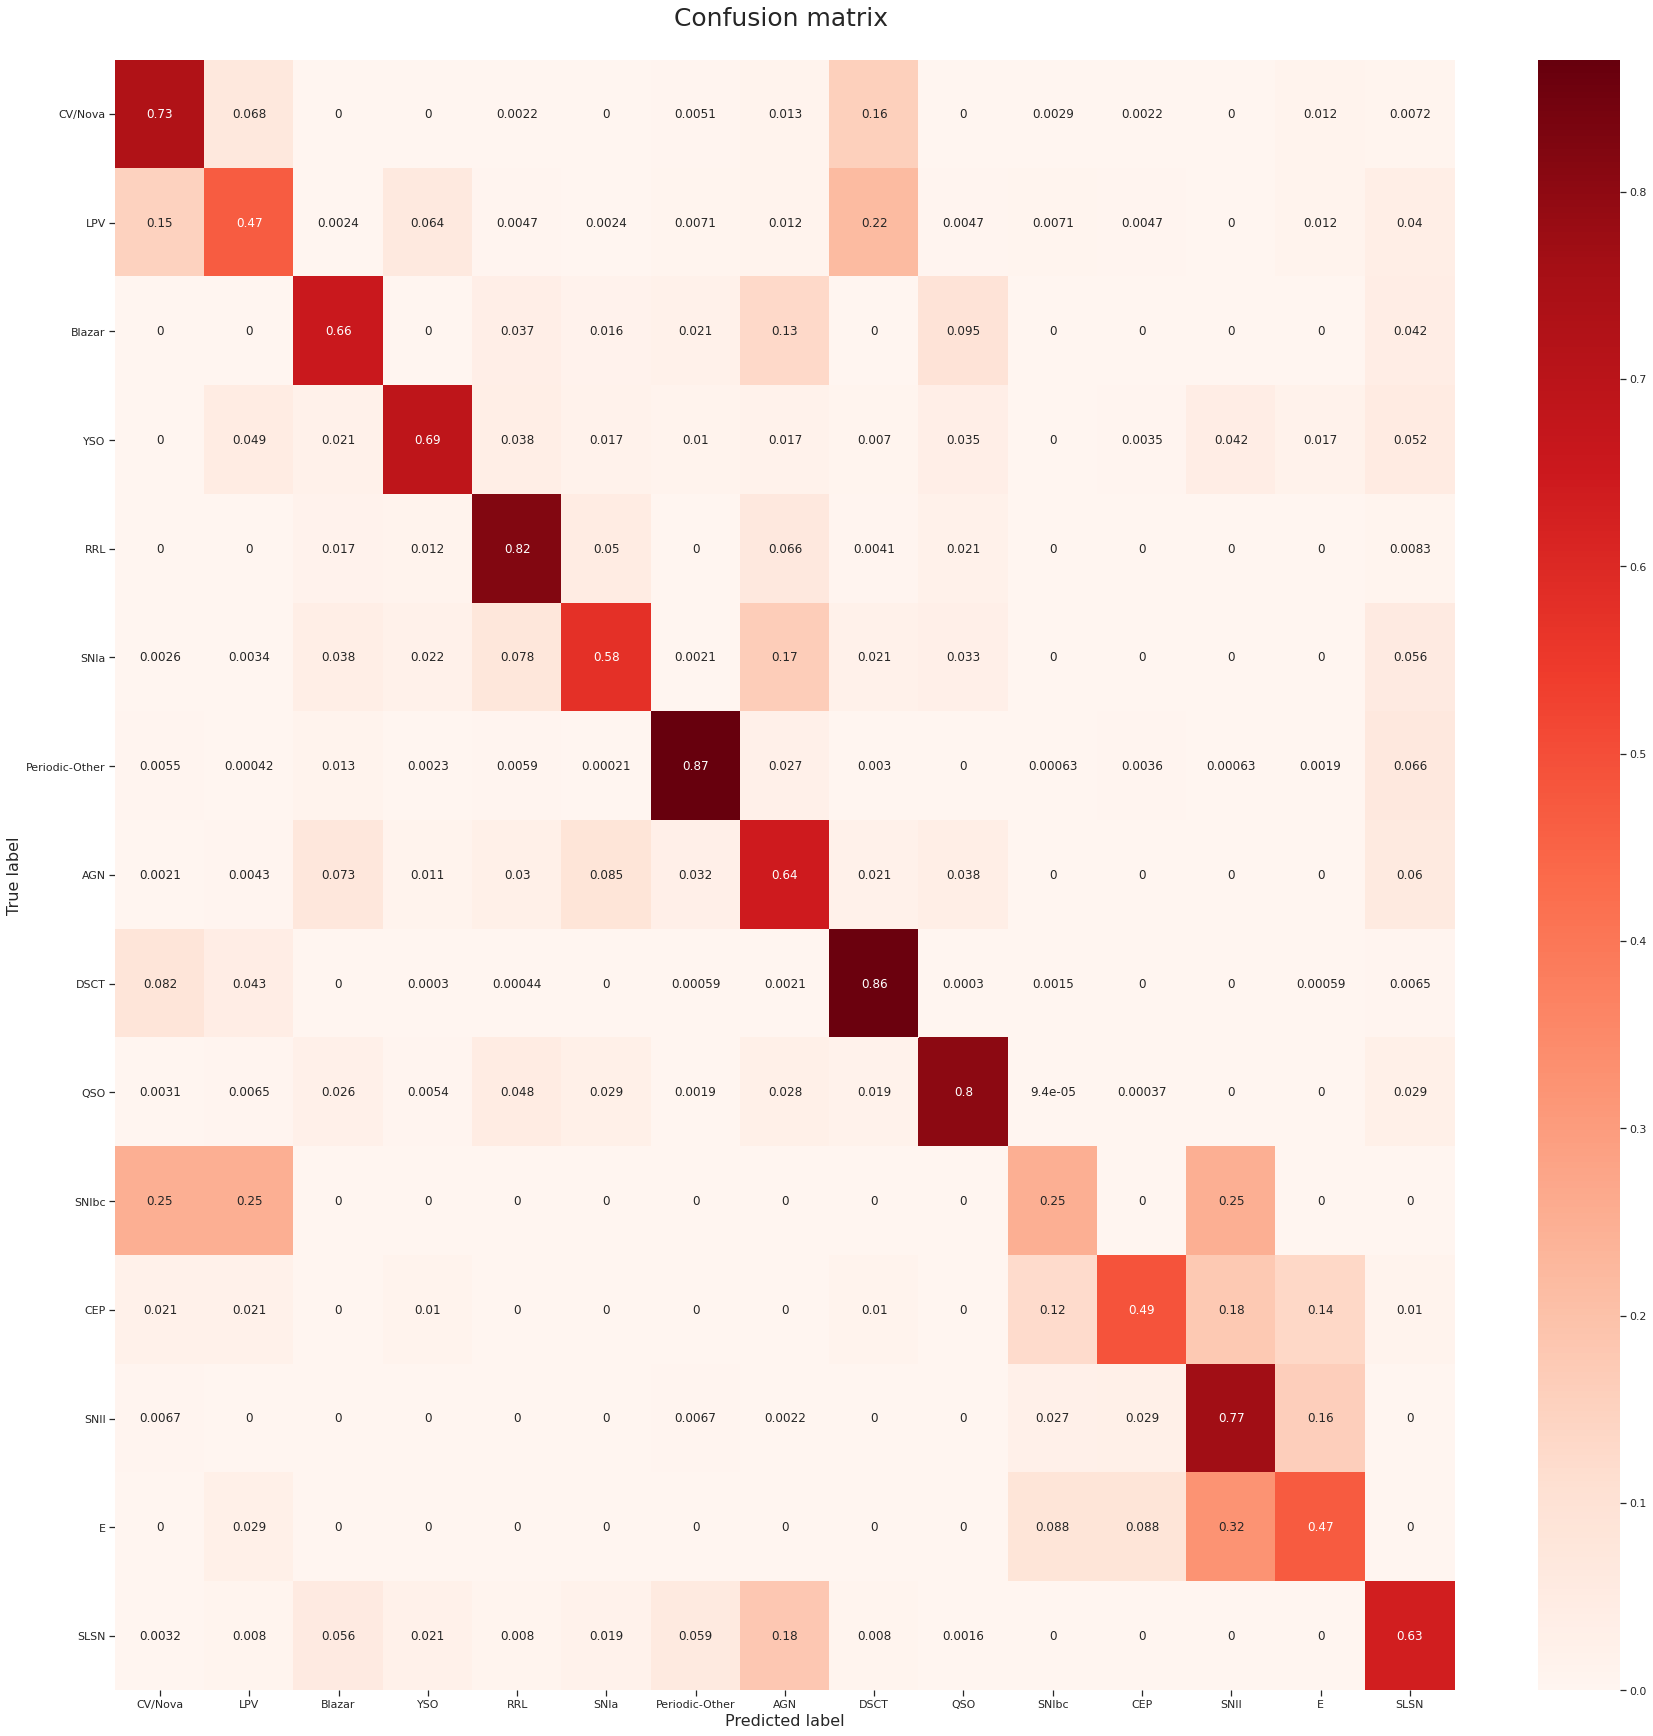

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import cross_validate
import itertools

cm = confusion_matrix(y_test, y_pred) 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(cm, index = classes, columns = classes)

g = sns.heatmap(df, annot=True, cmap="Reds")

g.set_yticklabels(g.get_yticklabels(), rotation = 0)

plt.rcParams["figure.figsize"] = (40,40) #Estandar en 20, 20

plt.title('Confusion matrix \n', size=25)
plt.xlabel('Predicted label', size=16)
plt.ylabel('True label', size=16)

In [35]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

scoring = ['precision_macro', 'recall_macro', 'accuracy', 'f1_macro']

precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')
accuracy = accuracy_score(y_test, y_pred)


print('Precision: {}  ({}%)'.format(precision, int(precision*100)))
print('Recall:    {}  ({}%)'.format(recall, int(recall*100)))
print('F1-score:  {}  ({}%)'.format(f1, int(f1*100)))
print('Accuracy:  {}  ({}%)'.format(accuracy, int(accuracy*100)))

Precision: 0.8811152780130573  (88%)
Recall:    0.7351646101070094  (73%)
F1-score:  0.7836458019003467  (78%)
Accuracy:  0.7351646101070094  (73%)


# Comentarios Meeting 1

Random Forest de ALeRCE -> https://github.com/alercebroker/lc_classifier/blob/52e147d67ed8fd549bf162c5ec6cdf06c545337a/lc_classifier/classifier/models.py#L56 - **implementado**

Quantile Tranformer para normalizar en vez de normalización de mínimo y máximo. - **listo**

Eliminar clases que aparecen poco o no aparecen en absoluto (ZZ, TDE, etc.) - **listo**

En el Random Forest se puede obtener el Ranking para simplificar la busqueda de features. - **listo**

Ver packs de características (https://docs.google.com/document/d/10-ZcclkeuGaviFsalC4wnTtrZMiitumQKaUmijk1tsA/edit)

Usar matriz de confusión normalizada (Filas suman 1) - **listo**